# ML to find radial velocities using FIRE data

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.colors as colors

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os.path
import sys
import gzip
import matplotlib.gridspec as gridspec

matplotlib.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [2]:
data = np.load('StarsWithRadialVelocity.npy')

In [3]:
data_cols = ['l', 'b','ra', 'dec', 'pmra', 'pmdec', 'parallax', 'radial_velocity',
             'phot_g_mean_mag', 'phot_bp_mean_mag', 'phot_rp_mean_mag',
             'pmra_error', 'pmdec_error', 'parallax_error', 'radial_velocity_error',
             'phot_g_mean_mag_error', 'phot_bp_mean_mag_error', 'phot_rp_mean_mag_error',
             'AccretedLabel'
            ]
#could train on radial_velocity_error

In [4]:
data = pd.DataFrame(data, columns=data_cols)

In [5]:
data.shape

(11400846, 19)

In [6]:
data.head()


,l,b,ra,dec,pmra,pmdec,parallax,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,pmra_error,pmdec_error,parallax_error,radial_velocity_error,phot_g_mean_mag_error,phot_bp_mean_mag_error,phot_rp_mean_mag_error,AccretedLabel
0,18.947771,17.087326,261.281075,-4.105546,0.304014,-2.012651,0.443537,44.472788,14.384683,14.678857,13.931516,0.091557,0.091557,0.044116,9.908263,0.000611,0.003929,0.003929,0.0
1,-4.978819,-41.542610,315.656827,-45.372252,15.768343,-16.975898,1.369992,-120.045033,12.405884,12.633657,12.030871,0.087001,0.087001,0.042780,2.036502,0.000342,0.002105,0.002105,0.0
2,-137.539419,-47.311996,60.814237,-25.789371,5.542696,9.388474,0.597262,83.063864,14.347357,14.619976,13.923520,0.091365,0.091365,0.044055,9.917098,0.000602,0.003861,0.003861,0.0
3,-68.315598,-32.353069,71.998054,-78.933526,14.320530,-13.669455,0.862436,-106.062495,14.062039,14.311761,13.648176,0.090130,0.090130,0.043668,7.792049,0.000544,0.003407,0.003407,0.0
4,85.879721,-52.988838,351.547535,3.638489,2.937268,5.109022,1.510236,-23.143291,14.677980,15.082906,14.107460,0.093275,0.093275,0.044678,11.110764,0.000683,0.004529,0.004529,0.0


In [7]:
data = data.drop(data[data.AccretedLabel > 0.0].index)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d

Removed 62,035 stars labeled as accreted. 

In [9]:
data = data.drop(data[data.radial_velocity > 100.0].index)

Removed 484569 stars with radial velocity greater than 100. 

In [10]:
data = data.drop(data[data.radial_velocity < -100.0].index)

In [11]:
# What columns to use?
use_cols = ['l', 'b','parallax','pmra','pmdec']
# Make the design matrix
X = data[use_cols].values
Y = (data['radial_velocity']).values
Y = (Y - np.mean(Y))/(np.std(Y))

In [12]:
print(X.shape)
print(Y.shape)

(10209688, 5)
(10209688,)


In [13]:
X_train, X_test, y_train, y_test = train_test_split(X[1:500000], Y[1:500000],
                                                    test_size = 0.2,
                                                    random_state=42)


In [14]:
#trying to add some weights to training data
#might weight the mean, but no weights on confidence model? (something to think about)
vr_real = y_train
counts, bins = np.histogram(vr_real,bins=np.linspace(-620,620,51))
bin_centers = (bins[1:]+bins[:-1])/2
interp_func = interp1d(bin_centers,(counts).astype('float'))
inv_weights = interp_func(vr_real)
weights = 1/inv_weights
weights = np.log(weights)
weights = weights - np.min(weights)

In [15]:
print(X_train.shape)
print(y_train.shape)
print('There are {0} stars in the training set'.format(np.sum(y_train)))
print()
print(X_test.shape)
print(y_test.shape)
print('There are {0} stars in the test set'.format(np.sum(y_test)))

(399999, 5)
(399999,)
There are -56.895894162107595 stars in the training set

(100000, 5)
(100000,)
There are 488.2340850296004 stars in the test set


I think this is giving me a negative output because it's summing over y_train, which is not the number of stars, but is instead the radial velocities. 

In [16]:
SS = StandardScaler()
X_train = SS.fit_transform(X_train)

In [17]:
# Now scale the test data using the same mean and standard deviation as found with the training data
X_test = SS.transform(X_test)

#visualize check data
for i, col in enumerate(use_cols):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.hist(data[col], bins=100)
    plt.yscale('log')
    plt.title('Data')
    
    plt.subplot(1,2,2)
    plt.hist(X_train[:, i], bins=100, alpha=0.5)
    plt.hist(X_test[:, i], bins=100, alpha=0.5)
    plt.yscale('log')
    plt.title('Scaled')
    
    plt.suptitle(col, y=1.01, fontsize=16)
    
    plt.tight_layout()

In [18]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [19]:
from keras import backend as K
from keras import callbacks as callbacks
global index 

In [20]:
class PlotErrors_Mean(callbacks.callbacks.Callback):
    def on_train_begin(self,logs = {}):
        self.i = 0
        self.train_data = [X_train, y_train]
        #what happens when training begins, initializations
        self.targets = []  # collect y_true batches
        self.outputs = []
        
        self.fig = plt.figure()
        #sc = plt.scatter(X_train[:,1], y_train, c =y_train, label = 'epoch '+str(self.i),marker = '.',cmap=plt.cm.YlOrRd)
        #plt.colorbar(sc, label = 'Absolute Error')
        #plt.clim(0,3)
    def on_epoch_end(self, epoch, logs={}):
        self.i += 1
        if self.i % 2 == 0:
            #what happens during each epoch
            x_train, y_train = self.train_data
            self.targets = y_train
            prediction = self.model.predict(x_train)
            self.outputs = prediction

            clear_output(wait=True)
            #plt.scatter(self.targets, self.outputs[:,0],color = 'blue', label = 'epoch '+str(self.i))
            #plt.errorbar(self.targets, self.outputs[:,0], yerr = self.outputs[:,1], color = 'red', ls = 'none')
            sc = plt.scatter(self.targets, self.outputs[:,0], c =self.outputs[:,1], label = 'epoch '+str(self.i),marker = '.',cmap=plt.cm.YlOrRd)
            x1 = np.linspace(-20,20,100)
            y1 = x1
            plt.plot(x1,y1,'k--')
            plt.xlim([-20, 20])
            plt.ylim([-20, 20])
            clb = plt.colorbar(sc,label = 'Absolute Error Epoch '+str(self.i))
            plt.clim(0,3)
            plt.ylabel('Vr predicted')
            plt.xlabel('Vr real')
            #legend = plt.legend()
            #plt.show();
            plt.savefig('error_images/error_epoch_'+str(self.i)+'.png')
            clb.remove()
            #legend.remove()
        
plot_errors_mean = PlotErrors_Mean()

For now, hold off on training PlotErrors_Conf, until can tell what epoch Mean stops on.

In [21]:
class PlotErrors_Conf(callbacks.callbacks.Callback):
    def on_train_begin(self,logs = {}):
        self.i = 40
        self.train_data = [X_train, y_train]
        #what happens when training begins, initializations
        self.targets = []  # collect y_true batches
        self.outputs = []
        
        self.fig = plt.figure()
        #sc = plt.scatter(X_train[:,1], y_train, c =y_train, label = 'epoch '+str(self.i),marker = '.',cmap=plt.cm.YlOrRd)
        #plt.colorbar(sc, label = 'Absolute Error')
        #plt.clim(0,3)
    def on_epoch_end(self, epoch, logs={}):
        self.i += 1
        if self.i % 2 == 0:
            #what happens during each epoch
            x_train, y_train = self.train_data
            self.targets = y_train
            prediction = self.model.predict(x_train)
            self.outputs = prediction

            clear_output(wait=True)
            #plt.scatter(self.targets, self.outputs[:,0],color = 'blue', label = 'epoch '+str(self.i))
            #plt.errorbar(self.targets, self.outputs[:,0], yerr = self.outputs[:,1], color = 'red', ls = 'none')
            sc = plt.scatter(self.targets, self.outputs[:,0], c =self.outputs[:,1], label = 'epoch '+str(self.i),marker = '.',cmap=plt.cm.YlOrRd)
            x1 = np.linspace(-20,20,100)
            y1 = x1
            plt.plot(x1,y1,'k--')
            plt.xlim([-20, 20])
            plt.ylim([-20, 20])
            clb = plt.colorbar(sc,label = 'Absolute Error Epoch '+str(self.i))
            plt.clim(0,3)
            plt.ylabel('Vr predicted')
            plt.xlabel('Vr real')
            #legend = plt.legend()
            #plt.show();
            plt.savefig('error_images/error_epoch_'+str(self.i)+'.png')
            clb.remove()
            #legend.remove()
        
plot_errors_conf = PlotErrors_Conf()

In [22]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1]) + 1e-6
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    sigma = K.print_tensor(SIGMA, message='SIGMA = ')
    
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    K.print_tensor(ARG, message = 'ARG')
    K.print_tensor(K.pow(2 * np.pi * K.square(SIGMA), -0.5), message='input to PREFACT = ')
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    return K.mean(ARG - PREFACT)


In [23]:
#training any checkpoint or early stopping? 
es = EarlyStopping(patience=5, restore_best_weights=True)

In [24]:
def ConstantLikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    ARG = -K.square(X - LOC) / (2.0)
    return K.mean(-ARG)


# Two network technique to calculate the error

In [25]:
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras.utils import plot_model
from IPython.display import clear_output

In [26]:
# del(inputs, MeanEst, MeanModel, ConfEst, ConfModel)
inputs = Input(shape=(5,))
MeanEst = (Dense(100, activation='relu'))(inputs)
MeanEst = (Dense(100, activation='relu'))(MeanEst)
MeanEst = (Dense(100, activation='relu'))(MeanEst)
MeanEst = (Dense(1, activation='linear'))(MeanEst)
MeanModel = Model(inputs=[inputs], outputs=MeanEst)

ConfEst= (Dense(100, activation='relu'))(inputs)
ConfEst= (Dense(100, activation='relu'))(ConfEst)
ConfEst= (Dense(100, activation='relu'))(ConfEst)
ConfEst= (Dense(1, activation='relu'))(ConfEst)
ConfModel = Model(inputs=[inputs], outputs=ConfEst)
#how can this give me a confidence output? the only thing that appears to define a confidence is the relu
#on the last layer...think about this.
#CombinedSub = Concatenate(axis=-1)([MeanEst, ConfEst])
CombinedSub = Concatenate(axis=-1)([MeanModel(inputs), ConfModel(inputs)])

CombinedModel = Model(inputs=[inputs], outputs=CombinedSub)
#plot_model(CombinedModel,to_file='demo.png',show_shapes=True)

In [27]:
CombinedModel.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 1)            20901       input_1[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            20901       input_1[0][0]                    
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 2)            0           model_1[1][0]                    
                                                                 model_2[1][0]              

In [28]:
ConfModel.trainable = False
MeanModel.trainable = True
CombinedModel.compile(loss=ConstantLikelihoodLossFunction,
                      optimizer='adam'
                     )
#why does the loss only return not nan when I use this ...I'm guessing it has to do with the log...
history = CombinedModel.fit(X_train,y_train,
                  epochs=200,
                  batch_size=2000,
                  validation_split=0.2,
                  #callbacks = [es],
                  sample_weight=weights
                 )

Train on 319999 samples, validate on 80000 samples
Epoch 1/200
319999/319999 [==============================] - 2s 7us/step - loss: 2.5474e-04 - val_loss: 2.4512e-04
Epoch 2/200
319999/319999 [==============================] - 2s 6us/step - loss: 2.4187e-04 - val_loss: 2.3740e-04
Epoch 3/200
319999/319999 [==============================] - 2s 6us/step - loss: 2.3767e-04 - val_loss: 2.3485e-04
Epoch 4/200
319999/319999 [==============================] - 2s 6us/step - loss: 2.3604e-04 - val_loss: 2.3371e-04
Epoch 5/200
319999/319999 [==============================] - 2s 6us/step - loss: 2.3480e-04 - val_loss: 2.3299e-04
Epoch 6/200
319999/319999 [==============================] - 2s 6us/step - loss: 2.3384e-04 - val_loss: 2.3228e-04
Epoch 7/200
319999/319999 [==============================] - 2s 6us/step - loss: 2.3341e-04 - val_loss: 2.3151e-04
Epoch 8/200
319999/319999 [==============================] - 2s 6us/step - loss: 2.3262e-04 - val_loss: 2.3125e-04
Epoch 9/200
319999/319999 [==

Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\\times' [U+d7], substitutin

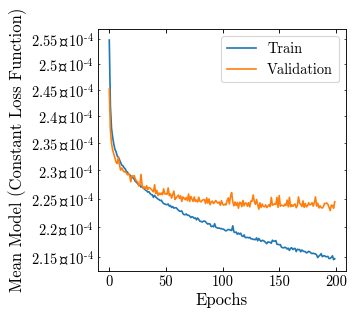

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Mean Model (Constant Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

In [30]:
print(y_train[1:10])

[ 1.86439302  0.760951   -1.70040124  1.7881685  -0.58032139  0.50716812
  0.87819906  0.44395405  1.57097075]


In [31]:
ConfModel.trainable = True
MeanModel.trainable = False
CombinedModel.compile(loss=LikelihoodLossFunction,
                      optimizer='adam'
                     )

history = CombinedModel.fit(X_train,y_train,
                  epochs=200,
                  batch_size=1000,
                  validation_split=0.2,
                  #callbacks = [plot_errors_conf],
                  sample_weight=weights
                 )

Train on 319999 samples, validate on 80000 samples
Epoch 1/200
319999/319999 [==============================] - 2s 6us/step - loss: 1356841.5151 - val_loss: 7.2901e-04
Epoch 2/200
319999/319999 [==============================] - 2s 6us/step - loss: 7.0321e-04 - val_loss: 7.0973e-04
Epoch 3/200
319999/319999 [==============================] - 2s 6us/step - loss: 6.9844e-04 - val_loss: 7.0848e-04
Epoch 4/200
319999/319999 [==============================] - 2s 7us/step - loss: 6.9756e-04 - val_loss: 7.0775e-04
Epoch 5/200
319999/319999 [==============================] - 2s 7us/step - loss: 6.9688e-04 - val_loss: 7.0724e-04
Epoch 6/200
319999/319999 [==============================] - 2s 7us/step - loss: 6.9645e-04 - val_loss: 7.0722e-04
Epoch 7/200
319999/319999 [==============================] - 2s 7us/step - loss: 6.9610e-04 - val_loss: 7.0671e-04
Epoch 8/200
319999/319999 [==============================] - 2s 7us/step - loss: 6.9572e-04 - val_loss: 7.0626e-04
Epoch 9/200
319999/319999 [

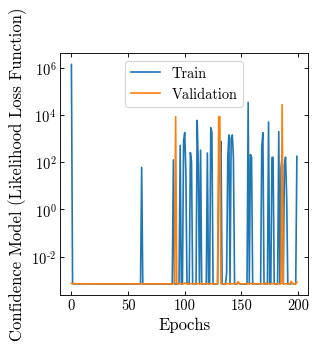

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Confidence Model (Likelihood Loss Function)')
plt.legend(['Train', 'Validation'])
plt.show()

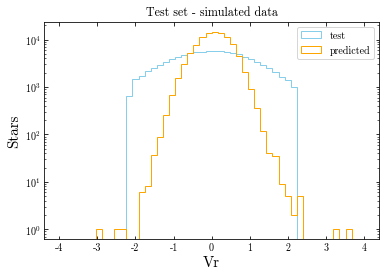

In [44]:
test_preds_2 = CombinedModel.predict(X_test)

plt.figure()
plt.hist(y_test, bins=50, range=(-4,4), histtype='step', color = 'skyblue', label = 'test' )
plt.hist(test_preds_2[:,0], bins=50, range=(-4,4), histtype='step',color = 'orange', label = 'predicted')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.legend(loc = "upper right")
plt.show()

In [34]:
np.any(np.isinf(test_preds_2[:,1]))

False

In [35]:
print(test_preds_2[1:10,:])

[[ 0.10517104  1.0926833 ]
 [-0.07102083  0.7523196 ]
 [-0.0072681   1.5396618 ]
 [ 0.569459    1.0656986 ]
 [-0.09332498  1.3289355 ]
 [ 1.1435682   0.8560789 ]
 [-0.27386773  1.4212297 ]
 [ 0.7066149   7.1599355 ]
 [ 0.512584    0.93884146]]


[ 1.0926833   0.7523196   1.5396618   1.0656986   1.3289355   0.8560789
  1.4212297   7.1599355   0.93884146  1.1902294   0.9388343   0.8054298
  1.0173608   2.1910439   0.55828226  9.874733    0.89524186  1.2508324
  0.54653907  0.83669734  1.3679187   1.195626    2.2437437   1.5342065
  1.1486083   4.7076335   0.78153867  1.5676662   1.0160993   0.587565
  2.0057926   0.9071434  18.460438    0.7527726   4.3448896   1.2622193
  0.97336346  1.6250877   1.2583263   1.0409136   0.95749635  0.7667522
  1.1095741   4.6082516   1.241636    1.1929823   1.5408705   0.9581245
  2.6818001 ]


Text(0, 0.5, 'Error on Vr predicted')

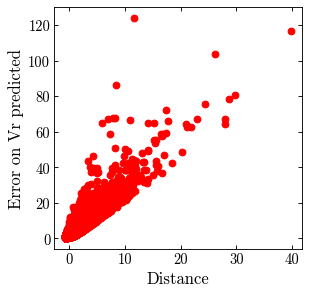

In [36]:
print(test_preds_2[1:50,1])
plt.scatter(X_test[:,2], test_preds_2[:,1], color = 'red')
#plt.errorbar(X_test[1:50,2], test_preds_2[1:50,0], yerr = test_preds_2[1:50,1], color = 'red',ls='none')
plt.xlabel('Distance')
plt.ylabel('Error on Vr predicted')
#does give a relu output...but I'm still not sure if this is exactly showing the error

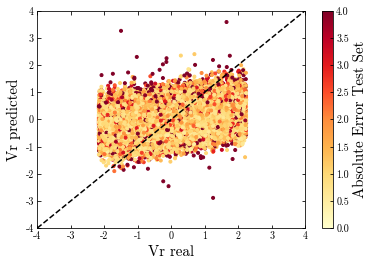

In [50]:
#plt.errorbar(y_test, test_preds_2[:,0], yerr = test_preds_2[:,1], color = 'red',ls='none')
sc = plt.scatter(y_test, test_preds_2[:,0], c =test_preds_2[:,1], label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
x1 = np.linspace(-200,200,1000)
y1 = x1
plt.plot(x1,y1,'k--')
plt.xlim([-200, 200])
plt.ylim([-200,200])
plt.ylabel('Vr predicted')
plt.xlabel('Vr real')
clb = plt.colorbar(sc, label = 'Absolute Error Test Set')
plt.clim(0,200)

Should also do a density plot for this one. Also plot loss function for second method (will need to include output for .fit). 

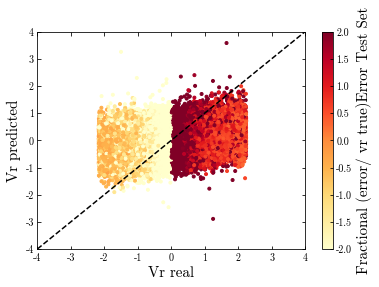

In [51]:
#plt.errorbar(y_test, test_preds_2[:,0], yerr = test_preds_2[:,1], color = 'red',ls='none')
sc = plt.scatter(y_test, test_preds_2[:,0], c =(test_preds_2[:,1]/(y_test+1e-6)), label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
x1 = np.linspace(-4,4,1000)
y1 = x1
plt.plot(x1,y1,'k--')
plt.xlim([-4, 4])
plt.ylim([-4,4])
plt.ylabel('Vr predicted')
plt.xlabel('Vr real')
clb = plt.colorbar(sc, label = 'Fractional (error/ vr true)Error Test Set')
plt.clim(-10,10)

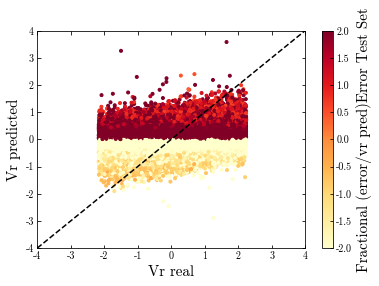

In [48]:
#plt.errorbar(y_test, test_preds_2[:,0], yerr = test_preds_2[:,1], color = 'red',ls='none')
sc = plt.scatter(y_test, test_preds_2[:,0], c =(test_preds_2[:,1]/(test_preds_2[:,0]+1e-6)), label = 'data',marker = '.',cmap=plt.cm.YlOrRd)
x1 = np.linspace(-4,4,100)
y1 = x1
plt.plot(x1,y1,'k--')
plt.xlim([-4, 4])
plt.ylim([-4,4])
plt.ylabel('Vr predicted')
plt.xlabel('Vr real')
clb = plt.colorbar(sc, label = 'Fractional (error/vr pred)Error Test Set')
plt.clim(-2,2)

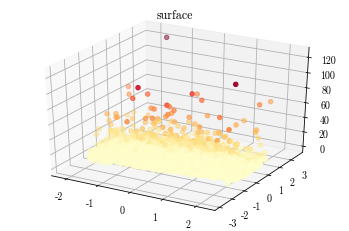

In [40]:
from mpl_toolkits import mplot3d
%matplotlib inline
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(y_test, test_preds_2[:,0], test_preds_2[:,1], c=test_preds_2[:,1], cmap=plt.cm.YlOrRd);
#ax.plot_surface(y_test, test_preds_2[:,0], test_preds_2[:,1], rstride=1, cstride=1,cmap=plt.cm.YlOrRd, edgecolor='none')
ax.set_title('surface');